In [1]:
import imageio
import numpy
import numpy as np
import matplotlib.pyplot as plt
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
from open_atmos_jupyter_utils import show_plot
import math
import os
import time
from matplotlib.animation import FuncAnimation
from numba import config
import numba


Input data : bathymetry

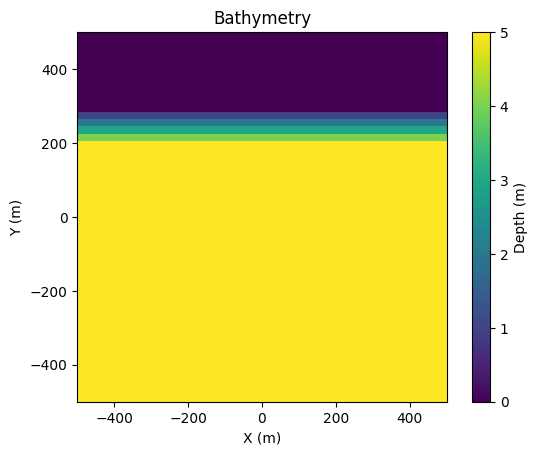

In [2]:
N = 51
L = 1000
dx = L / (N - 1)
d_max = 5.

x = np.linspace(-L / 2, L / 2, N)
y = np.linspace(-L / 2, L / 2, N)
X, Y = np.meshgrid(x, y)

b = np.zeros_like(X)

# for i in range(N):
#     for j in range(N):
#         if -300 <= X[j, i] <= 300 and -100 <= Y[j, i] <= 300:
#             b[j, i] = d_max
#         elif Y[j, i] < -100:
#             b[j, i] = d_max
#         elif Y[j, i] > 400:
#             b[j, i] = 0
#         elif Y[j, i] >= 0 and abs(X[j, i]) > 400:
#             b[j, i] = 0
#         elif abs(X[j, i]) >= 400 and -100 <= Y[j, i] < 0:
#             b[j, i] = d_max - (100 + Y[j, i]) * d_max / 100
#         elif abs(X[j, i]) <= 300 <= Y[j, i] <= 400:
#             b[j, i] = d_max - (Y[j, i] - 300) * d_max / 100
#         elif 400 >= abs(X[j, i]) >= 300 >= Y[j, i] >= 0:
#             b[j, i] = d_max - (abs(X[j, i]) - 300) * d_max / 100
#         elif 0 >= Y[j, i] >= -100 and 300 <= abs(X[j, i]) <= 400:
#             b[j, i] = d_max - d_max * (Y[j, i] + 100) * (abs(X[j, i]) - 300) / 10000
#         elif 400 >= Y[j, i] >= 300 <= abs(X[j, i]) <= 400:
#             b[j, i] = d_max * (400 - Y[j, i]) * (400 - abs(X[j, i])) / 10000

for i in range(N):
    for j in range(N):
        if 200 <= Y[j, i] <= 300:
            b[j, i] = d_max - (Y[j, i] - 200) * d_max / 100
        # elif 400 < Y[j, i]:
        #     b[j, i] = -d_max
        elif Y[j, i] < 200:
            b[j, i] = d_max
plt.imshow(b, extent=(-L / 2, L / 2, -L / 2, L / 2), origin='lower', cmap='viridis')
plt.colorbar(label="Depth (m)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Bathymetry")
plt.savefig("bathymetry.pdf")
plt.show()

Input data - h0

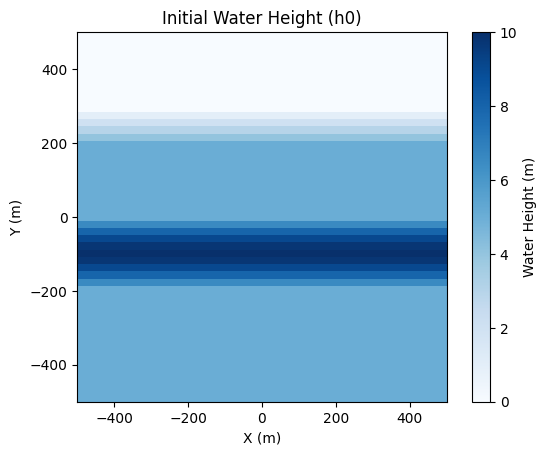

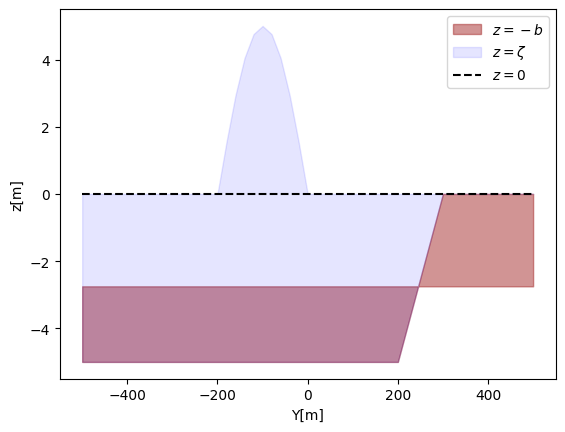

In [7]:
s = np.zeros(b.shape)
for i in range(N):
    for j in range(N):
        if -200 <= Y[j, i] <= 0:
            s[j, i] = np.sin((Y[j, i] + 200) * np.pi / 200) * 5
h0 = s + b
for i in range(N):
    for j in range(N):
        if h0[j, i] < 0:
            h0[j, i] = 0
plt.imshow(h0, extent=(-L / 2, L / 2, -L / 2, L / 2), origin='lower', cmap='Blues')
plt.colorbar(label="Water Height (m)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Initial Water Height (h0)")
plt.savefig("WaterHeight.pdf")
plt.show()


color='brown'; label='$b$'
plt.fill_between(y, -b[:, int(b.shape[1]/2)], -2.75, color=color, label=f'$z=-${label}', alpha=.5)

color='blue'; label='$\zeta$'
plt.fill_between(y, s[:, int(b.shape[1]/2)], -b[:, int(b.shape[1]/2)], color=color, label=f'$z=${label}', alpha=.1)

color='black'
plt.plot(y, np.full_like(y, 0), linestyle='--', color=color, label='$z=0$')
plt.legend()
plt.xlabel("Y[m]")
plt.ylabel("z[m]")
plt.savefig('initial.pdf')

In [4]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        self.bathymetry = bathymetry
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Periodic(), boundary_conditions.Periodic()],
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
            np.zeros((grid[X] + 1, grid[Y])),
            np.zeros((grid[X], grid[Y] + 1))
        ), **kwargs
        )
        self.solvers = {k: Solver(stepper, v, self.advector) for k, v in advectees.items()}

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        if np.amax(np.abs(courant_number)) > 1:
            print(np.amax(np.abs(courant_number)))
        assert np.amax(np.abs(courant_number)) <= 1
        return np.amax(np.abs(courant_number))

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float = 1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        times = []
        times_solver = []
        cs = numpy.zeros(nt+1)
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it:
                time_start = time.time()
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    c = self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                    cs[it] += c
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    if it:
                        time_start_solver = time.time()
                    self.solvers[key].advance(n_steps=1)
                    if it:
                        times_solver.append(time.time() - time_start_solver)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                if it:
                    times.append(time.time() - time_start)
            if it % outfreq == 0:
                print(f"Done step:{it}")
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output, cs/2, np.array(times), np.array(times_solver)

In [8]:
print(config.DISABLE_JIT)
config.DISABLE_JIT = True
print(config.DISABLE_JIT)
config.DISABLE_JIT = False
print(config.DISABLE_JIT)
nt = 780
outfreq = 20
dt = 0.1
times_nt = []
times_solv_nt = []
out, cs, times, times_solver = ShallowWaterEquationsIntegrator(h_initial=h0, bathymetry=b)(nt=nt, g=10, dt_over_dxy=(dt / dx, dt / dx), outfreq=outfreq)

False
True
False
Done step:0
Done step:20
Done step:40
Done step:60
Done step:80
Done step:100
Done step:120
Done step:140
Done step:160
Done step:180
Done step:200
Done step:220
Done step:240
Done step:260
Done step:280
Done step:300
Done step:320
Done step:340
Done step:360
Done step:380
Done step:400
Done step:420
Done step:440
Done step:460
Done step:480
Done step:500
Done step:520
Done step:540
Done step:560
Done step:580
Done step:600
Done step:620
Done step:640
Done step:660
Done step:680
Done step:700
Done step:720
Done step:740
Done step:760
Done step:780


Avg ToI = 0.04070387008862618
Avg ToS = 0.013183594055664846


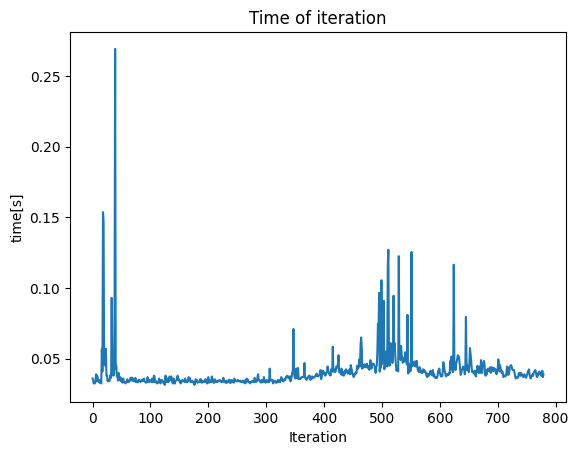

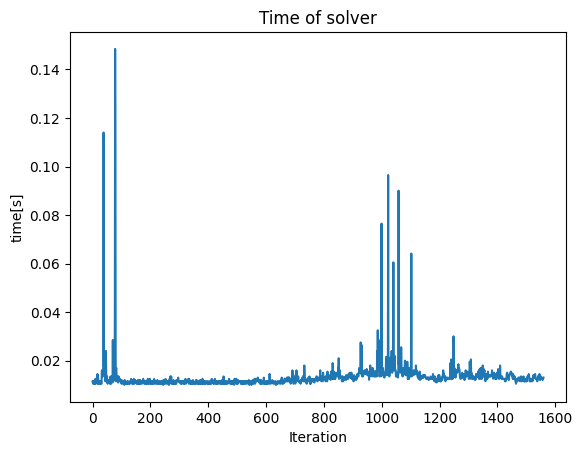

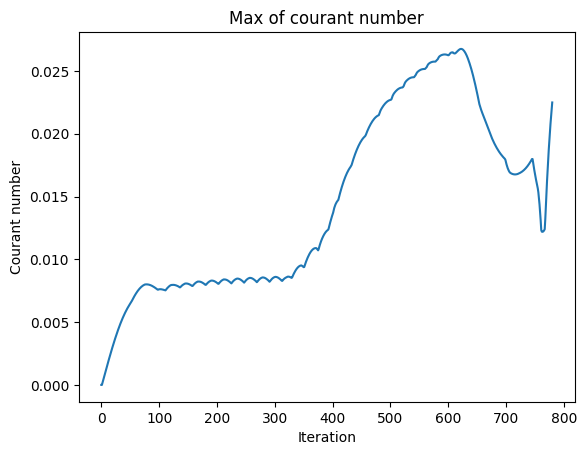

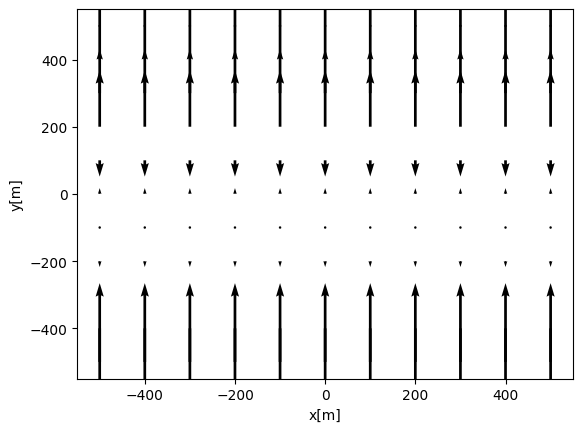

C:\Users\Dennisov\AppData\Local\Temp\ipykernel_4104\3247100270.py:51: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame) for frame in frames]
C:\Users\Dennisov\AppData\Local\Temp\ipykernel_4104\3247100270.py:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_1d = [imageio.imread(frame) for frame in frames_1d]


In [9]:
plt.figure()
plt.plot(range(times.shape[0]), times)
plt.xlabel("Iteration")
plt.ylabel("time[s]")
plt.title("Time of iteration")
plt.savefig("times_2dx.pdf")
print(f"Avg ToI = {np.sum(times)/times.shape[0]}")
plt.figure()
plt.plot(range(times_solver.shape[0]), times_solver)
plt.xlabel("Iteration")
plt.ylabel("time[s]")
plt.title("Time of solver")
plt.savefig("times_solver_2dx.pdf")
print(f"Avg ToS = {np.sum(times_solver)/times_solver.shape[0]}")
plt.figure()
plt.plot(range(cs.shape[0]), cs)
plt.xlabel("Iteration")
plt.ylabel("Courant number")
plt.title("Max of courant number")
plt.savefig("courant_n_2dx.pdf")
frames = []
frames_1d = []
dir = "./temp"
for i in range(len(out["h"])):
    psi = out['h'][i]
    plt.figure()
    plt.contourf(X, Y, psi, cmap="Blues", vmin=3, vmax=7, levels=40)
    plt.title(f"Time={dt * outfreq * i}s")
    plt.colorbar()
    plt.savefig(f"{dir}/frame_{i}.png")
    frames.append(f"{dir}/frame_{i}.png")
    if i==24:
        plt.savefig("psi.pdf")
    plt.close()
    psi_1d = out['h'][i][:,int(psi.shape[1]/2)]
    plt.figure()
    plt.plot(y, psi_1d - b[:, int(psi.shape[1]/2)], c='Blue')
    plt.plot(y, -b[:, int(psi.shape[1]/2)], c="Red")
    plt.title(f"Time={dt * outfreq * i}s")
    frames_1d.append(f"{dir}/frame_1d_{i}.png")
    plt.savefig(f"{dir}/frame_1d_{i}.png")
    if i == 24:
        plt.savefig("YZ.pdf")
    plt.close()
plt.figure()
plt.quiver(X[::5, ::5], Y[::5, ::5], out['vh'][24][::5, ::5], out['uh'][24][::5, ::5], scale=30)
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.savefig("Quiver.pdf")
plt.show()
images = [imageio.imread(frame) for frame in frames]
fps = 10
gif_path = "./wave_2dx.gif"
imageio.mimsave(gif_path, images, fps=fps)
for frame in frames:
    os.remove(frame)
images_1d = [imageio.imread(frame) for frame in frames_1d]
fps = 10
gif_path = "./wave_1d_2dx.gif"
imageio.mimsave(gif_path, images_1d, fps=fps)
for frame in frames_1d:
    os.remove(frame)